### **Environment setup & library imports**


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings( 'ignore' )

import numpy as np
import pandas as pd
import seaborn as sbn
import kagglehub
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.activations import relu,softmax , sigmoid , tanh,swish
from keras.layers import Dense , Input , Flatten , RandomBrightness , Dropout , ReLU,Normalization , BatchNormalization, MaxPool2D,Conv2D, GlobalAveragePooling2D, ELU, LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam , SGD , RMSprop
from keras.optimizers.schedules import ExponentialDecay , PolynomialDecay , PiecewiseConstantDecay , CosineDecay, CosineDecayRestarts,InverseTimeDecay
from keras.models import Sequential , Model
from keras.callbacks import LearningRateScheduler , ReduceLROnPlateau , EarlyStopping , ModelCheckpoint
from keras.utils import to_categorical
from keras.regularizers import l2 , l1
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.initializers import Zeros , GlorotNormal , GlorotUniform, HeNormal,HeUniform
from keras.losses import categorical_crossentropy , sparse_categorical_crossentropy , binary_crossentropy, mean_squared_error
from sklearn.datasets import load_wine, load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_moons

from mlxtend.plotting import plot_decision_regions

### **Download dataset from KaggleHub**

In [2]:
path = kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")
print("Path to dataset files:", path)

100%|██████████| 330M/330M [00:08<00:00, 39.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashishjangra27/face-mask-12k-images-dataset/versions/1


### **Data preprocessing & directory iterators**

In [4]:
train_path = '/root/.cache/kagglehub/datasets/ashishjangra27/face-mask-12k-images-dataset/versions/1/Face Mask Dataset/Train'
test_path = '/root/.cache/kagglehub/datasets/ashishjangra27/face-mask-12k-images-dataset/versions/1/Face Mask Dataset/Test'
val_path = '/root/.cache/kagglehub/datasets/ashishjangra27/face-mask-12k-images-dataset/versions/1/Face Mask Dataset/Validation'
train_data_generator = ImageDataGenerator(rescale=(1.0/255))
test_data_generator = ImageDataGenerator(rescale=(1.0/255))
val_data_generator = ImageDataGenerator(rescale=(1.0/255))
train_data_directory_iterator = train_data_generator.flow_from_directory(train_path, target_size = (100,100),class_mode = 'categorical',batch_size = 64)
test_data_directory_iterator = test_data_generator.flow_from_directory(test_path, target_size = (100,100),class_mode = 'categorical',batch_size = 64)
val_data_directory_iterator = val_data_generator.flow_from_directory(val_path, target_size = (100,100),class_mode = 'categorical',batch_size = 64)


Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### **Inspect batch shape from training data**

In [5]:
batch, labels = train_data_directory_iterator[0]
print(batch.shape)
print(labels.shape)

(64, 100, 100, 3)
(64, 2)


### **Build CNN model architecture**


In [6]:
model = Sequential([
    Conv2D(32, kernel_size=(5,5), padding='valid', strides=(1,1), activation='elu', input_shape=(100,100,3)),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(64, kernel_size=(3,3), padding='valid', strides=(1,1), activation='elu'),
    BatchNormalization(),
    MaxPool2D(2,2),
    Dropout(0.2),

    Conv2D(64, kernel_size=(4,4), padding='valid', strides=(1,1), activation='elu'),
    BatchNormalization(),
    MaxPool2D(2,2),
    Dropout(0.3),


    Flatten(),
    Dense(712, activation='elu' ),
    Dense(train_data_directory_iterator.num_classes, activation=softmax)
])

In [7]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 712)            │     4,557,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,426 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,646,106 (17.72 MB)

 Trainable params: 4,645,786 (17.72 MB)

 Non-trainable params: 320 (1.25 KB)

### **Setup callbacks & compile model**

In [8]:
checkpoint = ModelCheckpoint( filepath='best_model.weights.h5',monitor='val_accuracy',mode='max',save_best_only=True,save_weights_only=True,verbose=1)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, mode='min')
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

### **Train the model**


In [9]:
history = model.fit(train_data_directory_iterator,epochs=30,validation_data=val_data_directory_iterator,callbacks=[checkpoint, reduce_lr_cb])

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9166 - loss: 1.5586
Epoch 1: val_accuracy improved from -inf to 0.52125, saving model to best_model.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - accuracy: 0.9169 - loss: 1.5514 - val_accuracy: 0.5213 - val_loss: 11.3921 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9851 - loss: 0.0492
Epoch 2: val_accuracy improved from 0.52125 to 0.82750, saving model to best_model.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.9851 - loss: 0.0492 - val_accuracy: 0.8275 - val_loss: 1.2421 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9916 - loss: 0.0219
Epoch 3: val_accuracy improved from 0.82750 to 0.97000, saving model to best_model.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9916 - loss: 0.0219 - val_accuracy: 0.9700 - val_loss: 0.1980 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━

### **Plot training vs validation accuracy**


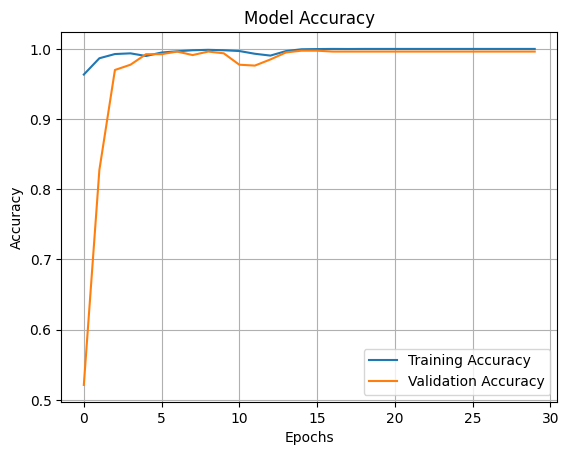

In [10]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.show()

### **Plot training vs validation loss**

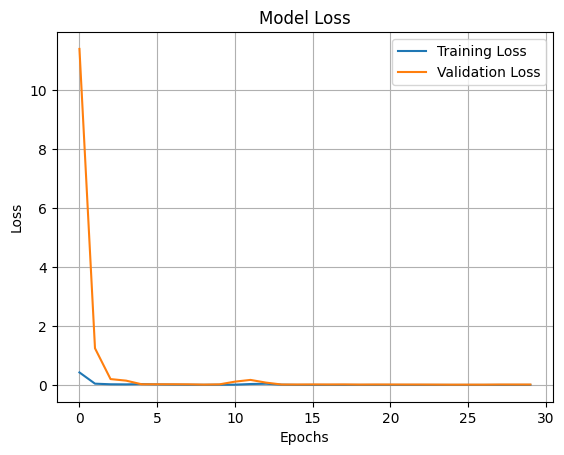

In [11]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()

### **Evaluate model on test dataset**








In [12]:
loss, acc = model.evaluate(test_data_directory_iterator)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {acc * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9972 - loss: 0.0213
Loss: 0.0545
Accuracy: 99.50%


### **Test model and display predictions**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


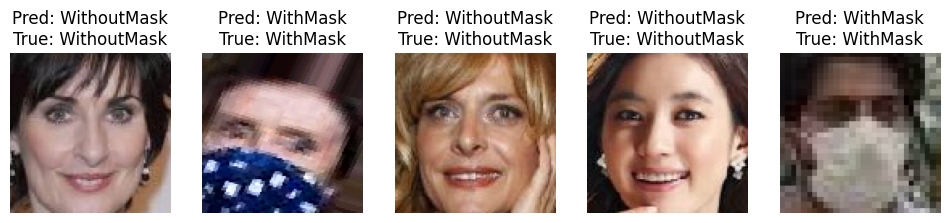

In [18]:
import numpy as np
import matplotlib.pyplot as plt

test_batch, test_labels = next(iter(test_data_directory_iterator))

predictions = model.predict(test_batch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)
class_labels = list(test_data_directory_iterator.class_indices.keys())

plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(test_batch[i])
    plt.title(f"Pred: {class_labels[predicted_classes[i]]}\nTrue: {class_labels[true_classes[i]]}")
    plt.axis("off")
plt.show()
